In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics,preprocessing,datasets
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRFRegressor

In [127]:
df = pd.read_csv('../Datasets/Cleaned.csv')

In [128]:
df.head()

,Country Name,Region,Income Group,Happiness Score,Year,SP.POP.DPND,GC.XPN.TOTL.GD.ZS,NY.GDP.MKTP.CD,NY.GDP.MKTP.KD.ZG,NY.GDS.TOTL.ZS,NV.IND.MANF.KD.ZG,SH.DYN.NMRT,SH.DYN.MORT,SP.POP.TOTL,AG.SRF.TOTL.K2,GC.TAX.TOTL.GD.ZS,NE.TRD.GNFS.ZS,SL.UEM.TOTL.NE.ZS
0,Afghanistan,South Asia,Low income,3.575,2015,88.768727,37.022570,1.990711e+10,1.451315,2.948180,0.409391,41.5,73.1,33736494,652860.0,7.585382,55.125527,3.561967
1,Afghanistan,South Asia,Low income,3.360,2016,86.570932,16.468816,1.904636e+10,2.260314,4.954033,1.087940,40.3,70.4,34656032,652860.0,18.687452,47.659055,4.360000
2,Afghanistan,South Asia,Low income,3.794,2017,84.587278,19.611100,1.954398e+10,2.665292,7.155705,0.748720,39.2,67.9,35530081,652860.0,20.952273,51.236881,4.276150
3,Angola,Sub-Saharan Africa,Lower middle income,4.033,2015,97.576199,20.818832,1.161936e+11,0.943576,30.823167,12.024337,30.6,88.9,27859305,1246700.0,11.002019,62.888521,5.558600
4,Angola,Sub-Saharan Africa,Lower middle income,3.866,2016,97.274212,17.511664,1.011239e+11,-2.580097,30.093522,11.638111,29.9,84.6,28813463,1246700.0,9.732512,53.370155,4.739756


In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 18 columns):
Country Name         414 non-null object
Region               414 non-null object
Income Group         414 non-null object
Happiness Score      414 non-null float64
Year                 414 non-null int64
SP.POP.DPND          414 non-null float64
GC.XPN.TOTL.GD.ZS    414 non-null float64
NY.GDP.MKTP.CD       414 non-null float64
NY.GDP.MKTP.KD.ZG    414 non-null float64
NY.GDS.TOTL.ZS       414 non-null float64
NV.IND.MANF.KD.ZG    414 non-null float64
SH.DYN.NMRT          414 non-null float64
SH.DYN.MORT          414 non-null float64
SP.POP.TOTL          414 non-null int64
AG.SRF.TOTL.K2       414 non-null float64
GC.TAX.TOTL.GD.ZS    414 non-null float64
NE.TRD.GNFS.ZS       414 non-null float64
SL.UEM.TOTL.NE.ZS    414 non-null float64
dtypes: float64(13), int64(2), object(3)
memory usage: 58.3+ KB


In [130]:
df = df.drop(columns=['Country Name','Region','Income Group'])

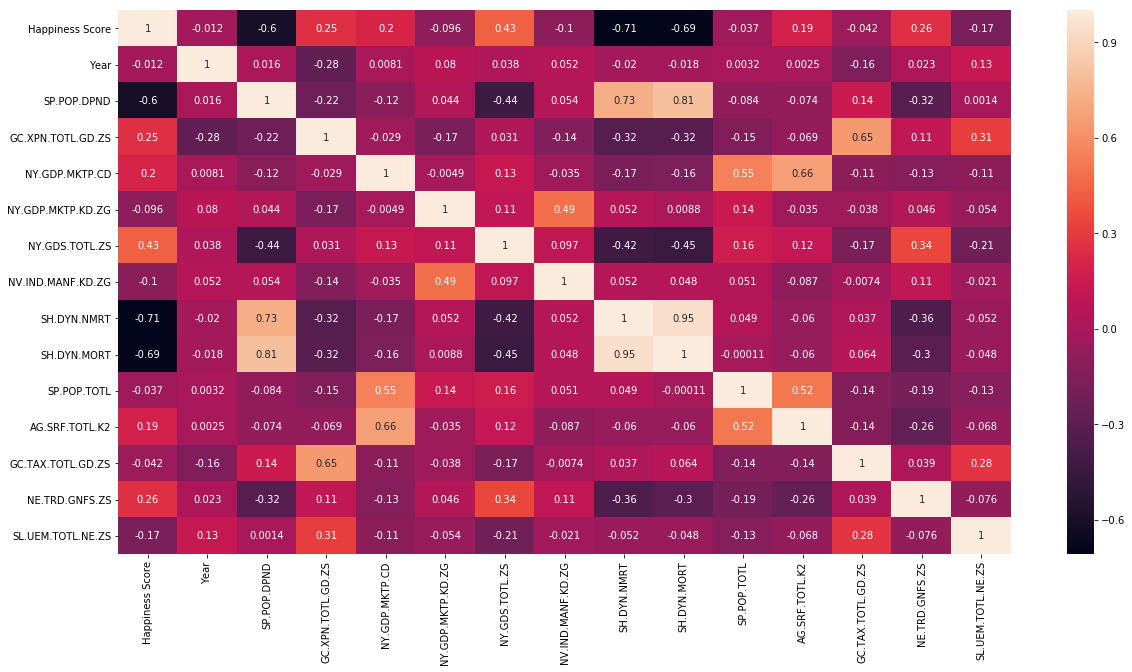

In [131]:
plt.figure(figsize=(20,10))
ax=sns.heatmap(df.corr(),annot=True)

In [132]:
corr_matrix = df.corr().abs()
high_corr_var=np.where(corr_matrix>0.8)
high_corr_var=[(corr_matrix.index[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]

In [133]:
cols=[]
for i in high_corr_var:
    if corr_matrix[i[0]]['Happiness Score'] > corr_matrix[i[1]]['Happiness Score']:
        cols.append(i[0])
    else:
        cols.append(i[1])
df.drop(columns=cols,inplace=True)

In [134]:
df.head()

,Happiness Score,Year,SP.POP.DPND,GC.XPN.TOTL.GD.ZS,NY.GDP.MKTP.CD,NY.GDP.MKTP.KD.ZG,NY.GDS.TOTL.ZS,NV.IND.MANF.KD.ZG,SP.POP.TOTL,AG.SRF.TOTL.K2,GC.TAX.TOTL.GD.ZS,NE.TRD.GNFS.ZS,SL.UEM.TOTL.NE.ZS
0,3.575,2015,88.768727,37.022570,1.990711e+10,1.451315,2.948180,0.409391,33736494,652860.0,7.585382,55.125527,3.561967
1,3.360,2016,86.570932,16.468816,1.904636e+10,2.260314,4.954033,1.087940,34656032,652860.0,18.687452,47.659055,4.360000
2,3.794,2017,84.587278,19.611100,1.954398e+10,2.665292,7.155705,0.748720,35530081,652860.0,20.952273,51.236881,4.276150
3,4.033,2015,97.576199,20.818832,1.161936e+11,0.943576,30.823167,12.024337,27859305,1246700.0,11.002019,62.888521,5.558600
4,3.866,2016,97.274212,17.511664,1.011239e+11,-2.580097,30.093522,11.638111,28813463,1246700.0,9.732512,53.370155,4.739756


***

In [135]:
train = df[df['Year']<2017].drop(columns=['Year'])
test = df[df['Year']==2017].drop(columns=['Year'])
train = train.reset_index()
test = test.reset_index()
del train['index'] 
del test['index']

In [136]:
x_train = train.drop(columns=['Happiness Score'])
y_train = train['Happiness Score']
x_test = test.drop(columns=['Happiness Score'])
y_test = test['Happiness Score']

***

In [137]:
random_grid   = {'min_child_weight':[1,2,3,4,5], 
                'gamma':[i/10.0 for i in range(3,6)],  
                'subsample':[i/10.0 for i in range(5,11)],
                'colsample_bytree':[i/10.0 for i in range(5,11)],
                'max_depth': [2,3,4,5,6,7,8,9,10],
                'objective':['reg:squarederror']}

In [138]:
xgb = XGBRFRegressor()
rf_random = RandomizedSearchCV(estimator =xgb,param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(x_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.6s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBRFRegressor(base_score=0.5, colsample_bylevel=1,
                                            colsample_bynode=0.8,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=1, max_delta_step=0,
                                            max_depth=3, min_child_weight=1,
                                            missing=None, n_estimators=100,
                                            n_jobs=1, nthread=None,
                                            objective='reg:linear',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_p...
                   iid='warn', n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9, 1.0],
     

In [139]:
bparams = rf_random.best_params_
bparams

{'subsample': 1.0,
 'objective': 'reg:squarederror',
 'min_child_weight': 5,
 'max_depth': 9,
 'gamma': 0.3,
 'colsample_bytree': 0.6}

In [140]:
param_grid = {'subsample': [bparams['subsample']],
 'min_child_weight': [bparams['min_child_weight']],
 'max_depth': [bparams['max_depth']],
 'gamma': [bparams['gamma']],
 'colsample_bytree': [bparams['colsample_bytree']],
  'objective':['reg:squarederror']}

In [141]:
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(x_train,y_train)
grid_search.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


{'colsample_bytree': 0.6,
 'gamma': 0.3,
 'max_depth': 9,
 'min_child_weight': 5,
 'objective': 'reg:squarederror',
 'subsample': 1.0}

In [142]:
best_grid = grid_search.best_estimator_
best_grid

XGBRFRegressor(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
               colsample_bytree=0.6, gamma=0.3, learning_rate=1,
               max_delta_step=0, max_depth=9, min_child_weight=5, missing=None,
               n_estimators=100, n_jobs=1, nthread=None,
               objective='reg:squarederror', random_state=0, reg_alpha=0,
               reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
               subsample=1.0, verbosity=1)

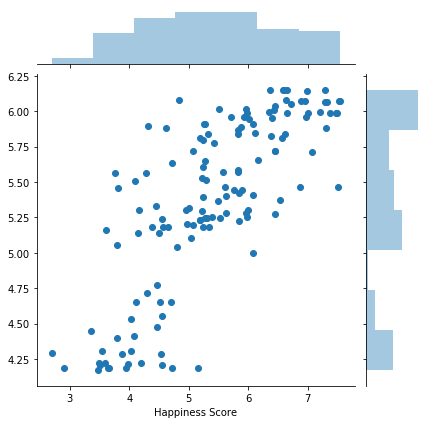

In [143]:
predictions = best_grid.predict(x_test)
sns.jointplot(y_test,predictions)

In [144]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print("Training set score: {:.2f}".format(grid_search.score(x_train,y_train)))
print("Test set score: {:.2f}".format(grid_search.score(x_test,y_test)))

MAE: 0.6194577113441804
MSE: 0.6061454868826458
RMSE: 0.7785534579479085
Training set score: 0.58
Test set score: 0.54


***